In [56]:
import pandas as pd
import numpy as np
import sklearn
import os

#versions
print('Pandas Version: {}'.format(pd.__version__))
print('Numpy Version: {}'.format(np.__version__))
print('Sci-Kit Learn Version: {}'.format(sklearn.__version__))

#visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

###### Below Parameters must be met #########
                                            #
# 1. Boxers must be less than 190 pounds    #
#    and over 100 pounds.                   #       
# 2. Must have the same stance              #
# 3. Must be under the age of 50            #
                                            #
#############################################

# Dataset taken from Kaggle.com


Pandas Version: 0.22.0
Numpy Version: 1.14.2
Sci-Kit Learn Version: 0.19.1


In [57]:
# Importing the dataset:
file = pd.read_csv(r'C:\Users\Adam\Desktop\WinPython-64bit-3.5.3.0Qt5\Datasets\Datasets 1\boxing-bouts\bouts_out_new.csv')


df2 = pd.DataFrame(file)

##### Data Exploration #####

print(df2.head())

### List out all the column names
print('Column Names:\n {}\n'.format(list(df2)))
print('Info: {}\n'.format(df2.info()))


### Picking columns I want for the model
df2 = df2[['age_A','age_B','height_A','height_B','weight_A', 'weight_B', 'reach_A', 'reach_B',
           'won_A', 'won_B', 'lost_A', 'lost_B', 'kos_A', 'kos_B', 'result', 'decision']]

# Removing outliers, and setting parameters for more reasonable values 
fil = ((df2.height_A < 224) & (df2.height_A > 147) &
       (df2.weight_B < 190) & (df2.weight_B > 100) &
      (df2.height_B < 224) & (df2.height_B > 147) &
      (df2.age_A < 50) & (df2.age_A > 16) &
      (df2.age_B < 50) & (df2.age_B > 16) &
      (df2.reach_A < 250) & (df2.reach_A > 130) &
      (df2.reach_B < 250) & (df2.reach_B > 130))

df2=df2[fil]


### Drop any Nan values
df3 = df2.dropna()


### Removing 'draw' from results as we want to keep it binary for simplicity 
df4 = df3[df3.result != 'draw']


### Deleting the weight columns now that I've filtered out anything above 200 pounds since weight classes in
#   in boxing are defined up to the Heavyweight Class. Also dropping Judges decision for model simplicity.
df4.drop(['weight_A','weight_B','decision'],axis=1, inplace=True)


# Check is there are any Nan in data
#print(np.any(np.isnan(df4)))


# Checks to see if there are any infinite values
#print(np.all(np.isfinite(df4)))


# Reset the index:
df5 = df4.reset_index()


# Drop the original, now out of order, index:
del df5['index']


### Check to see if we have any 'draw' left in the results column
### Value counts - see how many data points each columns has -Note dataset is imbalanced towards win_A
print(df4.result.value_counts())


   age_A  age_B  height_A  height_B  reach_A  reach_B  stance_A  stance_B  \
0   35.0   27.0     179.0     175.0    178.0    179.0  orthodox  orthodox   
1   26.0   31.0     175.0     185.0    179.0    185.0  orthodox  orthodox   
2   28.0   26.0     176.0     175.0      NaN    179.0  orthodox  orthodox   
3   25.0   29.0     175.0     174.0    179.0    180.0  orthodox  orthodox   
4   25.0   35.0     175.0     170.0    179.0    170.0  orthodox  orthodox   

   weight_A  weight_B   ...     kos_A  kos_B  result  decision  judge1_A  \
0     160.0     160.0   ...        33   34.0    draw        SD     110.0   
1     164.0     164.0   ...        34   32.0   win_A        UD     120.0   
2     154.0     154.0   ...        13   33.0   win_B        KO       NaN   
3     155.0     155.0   ...        32   19.0   win_A        KO      47.0   
4     155.0       NaN   ...        32   33.0   win_A        UD     118.0   

   judge1_B  judge2_A  judge2_B judge3_A judge3_B  
0     118.0     115.0     11

C:\Users\Adam\Desktop\WinPython-64bit-3.5.3.0Qt5\python-3.5.3.amd64\lib\site-packages\ipykernel\__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


             age_A     age_B  height_A  height_B   reach_A   reach_B  \
age_A     1.000000  0.196929  0.029092  0.155073  0.066356  0.136803   
age_B     0.196929  1.000000  0.159053  0.054043  0.154524  0.096756   
height_A  0.029092  0.159053  1.000000  0.634139  0.824891  0.572893   
height_B  0.155073  0.054043  0.634139  1.000000  0.563693  0.801760   
reach_A   0.066356  0.154524  0.824891  0.563693  1.000000  0.535604   
reach_B   0.136803  0.096756  0.572893  0.801760  0.535604  1.000000   
won_A     0.351824 -0.035660 -0.041544  0.076478  0.011994  0.088423   
won_B     0.102613  0.236295  0.012859  0.010839  0.070741  0.043566   
lost_A    0.316637 -0.096865 -0.062523  0.041230 -0.011185  0.065061   
lost_B   -0.032988  0.317855  0.022119 -0.063739  0.057148  0.001476   
kos_A     0.449414  0.078639 -0.002421  0.079949  0.049967  0.081436   
kos_B     0.195233  0.322437  0.055975  0.067079  0.099787  0.097658   

             won_A     won_B    lost_A    lost_B     kos_A     

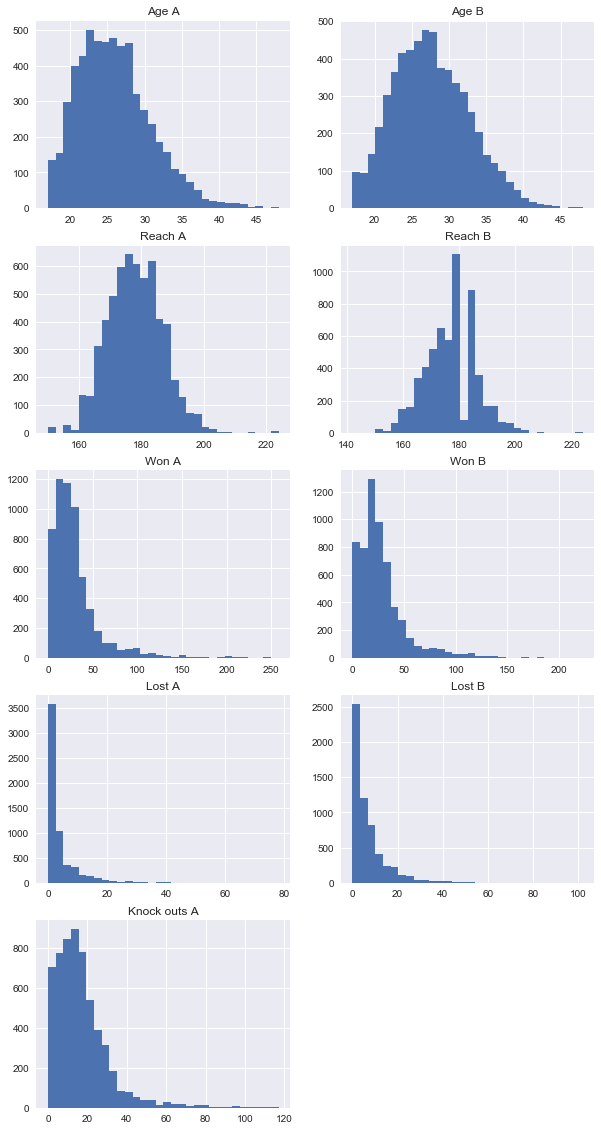

In [58]:

### Note that the dataset is imbalanced. We have 5003 for Win_A and 858 for Win_B

###get the correlations between data
print(df5.corr())

### Taking a quick look here to see if correlations make sense. We see a good correlation with age and wins, and 
### height and reach. These make sense. 


### Histograms

fig = plt.figure(figsize = (10,20))

fig2 = plt.figure(figsize = (10,20))

# The Data
x = df5['age_A']
y = df5['age_B']
w = df5['reach_A']
z = df5['reach_B']
m = df5['won_A']
n = df5['won_B']
p = df5['lost_A']
q = df5['lost_B']
r = df5['kos_A']
s = df5['kos_B']

# add subplots to overal figure, (221) = (rows, columns, graph placement). 
ax1 = fig.add_subplot(521)
ax2 = fig.add_subplot(522)
ax3 = fig.add_subplot(523)
ax4 = fig.add_subplot(524)
ax5 = fig.add_subplot(525)
ax6 = fig.add_subplot(526)
ax7 = fig.add_subplot(527)
ax8 = fig.add_subplot(528)
ax9 = fig.add_subplot(529)



# Define what kind of graph each subplot will be, and where to get the data for it
ax1.hist(x, bins = 30)
ax2.hist(y, bins = 30)
ax3.hist(w, bins = 30)
ax4.hist(z, bins = 30)
ax5.hist(m, bins = 30)
ax6.hist(n, bins = 30)
ax7.hist(p, bins = 30)
ax8.hist(q, bins = 30)
ax9.hist(r, bins = 30)


# Set titles
ax1.title.set_text('Age A')
ax2.title.set_text('Age B')
ax3.title.set_text('Reach A')
ax4.title.set_text('Reach B')
ax5.title.set_text('Won A')
ax6.title.set_text('Won B')
ax7.title.set_text('Lost A')
ax8.title.set_text('Lost B')
ax9.title.set_text('Knock outs A')


### We see severalfeatures have a Gaussian distribution, and some are skewed right. 


In [59]:
###### Engineering New Features ########

### Make a new feature for height difference
df5['height_diff'] = df5.height_A - df5.height_B


### Make a new feature for age difference
df5['age_diff'] = df5.age_A - df5.age_B


### Make a new feature for reach difference
df5['reach_diff'] = df5.reach_A - df5.reach_B


### Make a new feature for KO percentage of wins
df5['ko_percent_A'] = df5.kos_A  / df5.won_A 
df5['ko_percent_B'] = df5.kos_B  / df5.won_B


### Make a new feature for Win Percentage
df5['win_percent_A'] = df5.won_A / (df5.won_A +  df5.lost_A) 
df5['win_percent_B'] = df5.won_B / (df5.won_B +  df5.lost_B) 


df5.replace({'win_A': 0, 'win_B': 1}, inplace=True)

### Removing these columns because of win_percentage and ko_percentage engineered features above.
df5.drop(['won_A','won_B','lost_A','lost_B','kos_A','kos_B'],axis=1, inplace=True)

print(df5.head())


   age_A  age_B  height_A  height_B  reach_A  reach_B  result  height_diff  \
0   26.0   31.0     175.0     185.0    179.0    185.0       0        -10.0   
1   25.0   29.0     175.0     174.0    179.0    180.0       0          1.0   
2   23.0   31.0     175.0     175.0    179.0    188.0       0          0.0   
3   22.0   28.0     175.0     177.0    179.0    175.0       0         -2.0   
4   21.0   40.0     175.0     174.0    179.0    180.0       0          1.0   

   age_diff  reach_diff  ko_percent_A  ko_percent_B  win_percent_A  \
0      -5.0        -6.0      0.708333      0.640000       0.979592   
1      -4.0        -1.0      0.695652      0.612903       0.978723   
2      -8.0        -9.0      0.720930      0.631579       0.977273   
3      -6.0         4.0      0.725000      0.600000       1.000000   
4     -19.0        -1.0      0.743590      0.847826       1.000000   

   win_percent_B  
0       0.961538  
1       0.911765  
2       0.950000  
3       0.882353  
4       0.86792

Shape of y_train: (3359,)
Type of y_train: <class 'pandas.core.series.Series'>
                  age_A     age_B  height_A  height_B   reach_A   reach_B  \
age_A          1.000000  0.165691  0.033861  0.165684  0.062194  0.137045   
age_B          0.165691  1.000000  0.163364  0.062535  0.146021  0.096902   
height_A       0.033861  0.163364  1.000000  0.633763  0.822841  0.571500   
height_B       0.165684  0.062535  0.633763  1.000000  0.564668  0.800328   
reach_A        0.062194  0.146021  0.822841  0.564668  1.000000  0.532077   
reach_B        0.137045  0.096902  0.571500  0.800328  0.532077  1.000000   
height_diff   -0.153656  0.118228  0.430937 -0.424905  0.304218 -0.264837   
age_diff       0.634089 -0.657509 -0.102223  0.077550 -0.066979  0.028722   
reach_diff    -0.081650  0.045457  0.229311 -0.273104  0.450036 -0.516654   
ko_percent_A   0.010694  0.171460  0.115744  0.061819  0.098992  0.054771   
ko_percent_B   0.152070  0.101481  0.079459  0.142839  0.068965  0.122571 

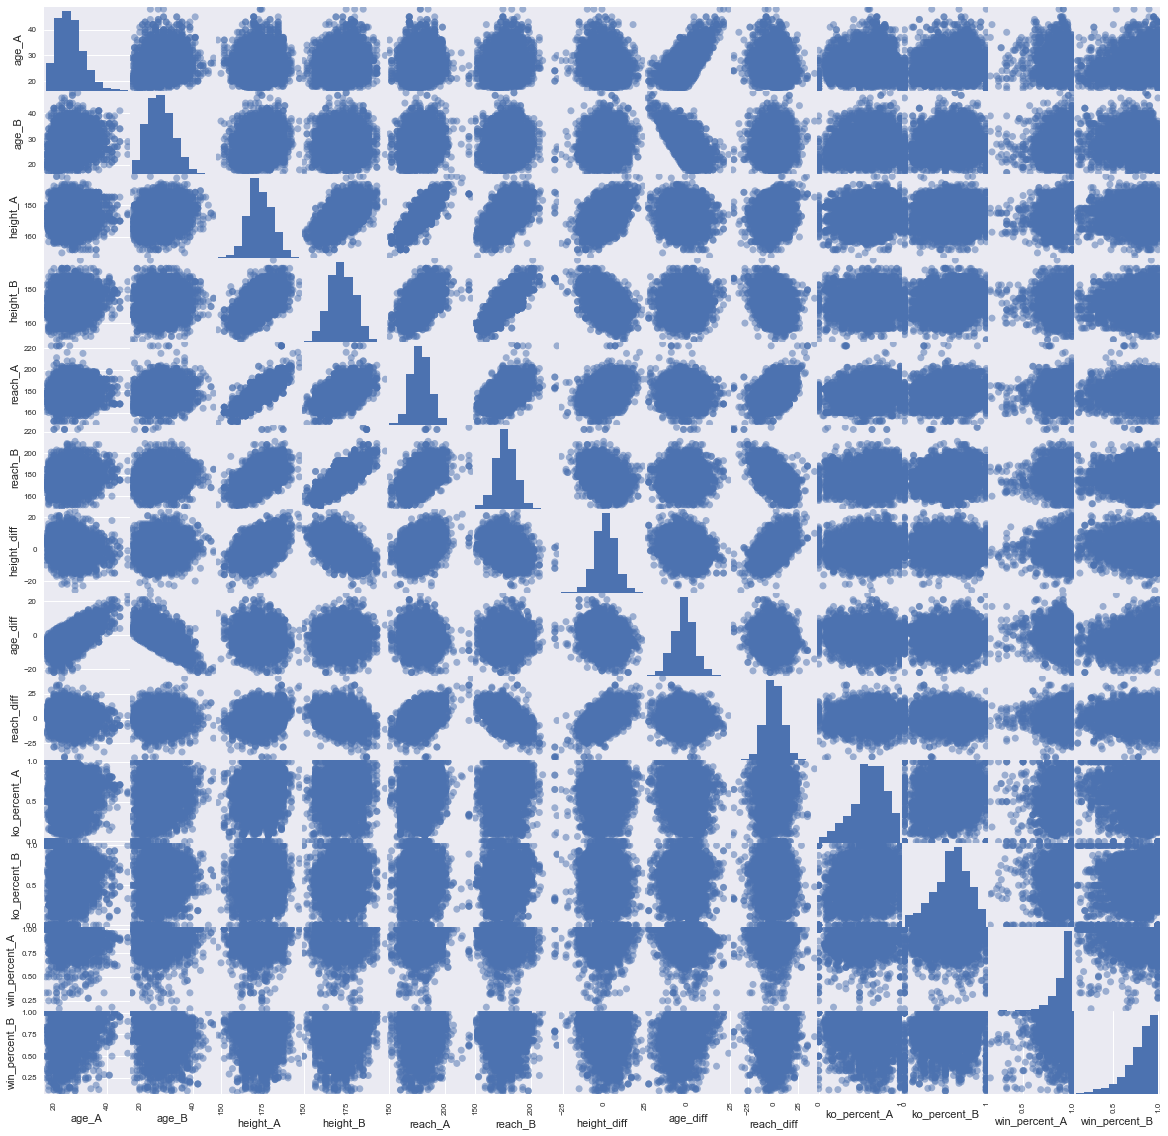

In [60]:

from pandas.plotting import scatter_matrix

# Dropping the 'result' column to enter into y_train
df5 = df5.dropna()

y = df5['result']

df5.drop('result',axis=1, inplace=True) 

# Splitting the data into train, test, and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(df5, y, random_state = 0)

### Once more to make validation set
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state = 0)


print('Shape of y_train: {}'.format(y_train.shape))
print('Type of y_train: {}'.format(type(y_train)))

# Scatter Matrix to visualize correlations between features:
pd.plotting.scatter_matrix(df5,figsize = (20,20), marker='o')

# Taking another look at the data after engineering features and removing columns 
print(df5.corr())
print(df5.describe())
print(df5.info())


In [61]:

########## PIPELINES ###########

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### I'm using three algorithms: Support Vector Classifier, Logistic Regression, and Random Forest Classifier. Preliminary
### testing showed that Linear Models,Ridge Regression, and K-Nearest Neightbors yielded poor results so I have narrowed 
### it down to these three.  

# The pipelines:
pipe_svc = Pipeline([('preprocessing', StandardScaler()),('classifier', SVC())])
pipe_lr = Pipeline([('preprocessing', StandardScaler()),('classifier', LogisticRegression())])
pipe_rf = Pipeline([('preprocessing', StandardScaler()),('classifier', RandomForestClassifier(random_state=42))])


### Parameter Grids for the classifiers to be used:

# SVC:
param_grid_svc = [{'classifier': [SVC()], 
                
     'preprocessing': [StandardScaler(), None],
                
     'classifier__gamma': [1, 10, 100 ],
                
     'classifier__C':[1, 10, 100]}]

# Logistic Regression:
param_grid_logreg = [{'classifier': [LogisticRegression (class_weight='balanced')],
                
     'preprocessing':[StandardScaler(), None]}]

# Random Forest:
param_grid_rf = [{
    'classifier': [RandomForestClassifier(n_jobs =3)],
               
    'classifier__max_features':[3,5,7],
               
    'classifier__n_estimators': [100,200],
               
    'classifier__max_depth': [3,5,7],
                
    'preprocessing':[StandardScaler()]}]


### Building Gridsearches:

gs_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5)

gs_logreg = GridSearchCV(pipe_lr, param_grid_logreg, cv=5)

gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5)

### List of Grid searches for easier iteration
grids = [gs_svc, gs_logreg, gs_rf]


for gs in grids:
    # Fit grid search 
    gs.fit(X_train, y_train)
    # Best Parameters:
    print('\nBest Parameters: %s\n' % gs.best_params_)
    # Training Set Score:
    print("Training set Score: {}".format(gs.score(X_train, y_train)))
    # Best Score:
    print('Best Accuracy: %s' % gs.best_score_)
    #Predictions:
    y_pred = gs.predict(X_test)
    # Best Scores:
    print('Best Scores: %s\n' % accuracy_score(y_test,y_pred))
    
    # Confusion Matrix for each estimator:
    confusion = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n{}\n'.format(confusion))
    
    # Classification Reports:
    print(classification_report(y_test,y_pred, target_names =['Win A','Win B'] ))


#### Dummy Classifier #####

# Let's compare this to a Dummy Classifer, which we can use as a baseline comparison to the results above:

### Picks most frequently occuring value (in this case dataset is imbalanced - More 'Win_A') - Will always choose Win_A.
dummy_majority = DummyClassifier(strategy ='most_frequent').fit(X_train,y_train)


### Use Dummy Classifier to see how random values affect results
dummy = DummyClassifier().fit(X_train,y_train)


print('\nMost Frequent Score: {}\n'.format(dummy_majority.score(X_test, y_test)))
print('Dummy Classifier Score: {}\n'.format(dummy.score(X_test, y_test)))




Best Parameters: {'classifier__C': 10, 'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__gamma': 10, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Training set Score: 0.9997022923489134
Best Accuracy: 0.8761536171479607
Best Scores: 0.8742857142857143

Confusion Matrix:
[[1191    0]
 [ 176   33]]

             precision    recall  f1-score   support

      Win A       0.87      1.00      0.93      1191
      Win B       1.00      0.16      0.27       209

avg / total       0.89      0.87      0.83      1400


Best Parameters: {'preprocessing': None, 'classifier': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
 

In [62]:

#### REVIEWING RESULTS: #####

# 1. Logistic Regression clearly performs the worst. Let's focus on SVC and Random Forest.
# 2. I see the SVC is hitting a nearly perfect score on the training set, which is a red flag for overfitting. 
# 3. SVC does better across the board in the classificaton report regarding Precision, Recall and F1 Score.
# 4. I am more interested in a higher precision score than recall because we are trying to minimize False Positives/Negatives
#    since False Positives/Negatives can result in betting on the wrong Boxer. SVC has 100 precision on Win_B and 87 Win_A.

# Confusion Matrices: 

# 5. SVC has ZERO False Positives (correctly predicting all Win_B), and only 176 False Negatives vs Random
#    Forest's 6 and 198 respectively. 
# 6. For True Negatives/Positives we have: [Random Forest - 1185/11] vs [SVC - 1191/33] -- SVC is better here once again.
# 7. Using the Dummy Classifier baseline, the SVC is 12% more accurate than the Dummy Classifier baseline.


# Overall, even with the concern of overfitting on the training set, it looks like the Support Vector Classifier 
# is still the best choice when using C= 10 and Gamme = 10 as parameters.


In [63]:


#Using pickle to serialize/save the model.
'''
import pickle, sys


modulename = 'pickle'
if modulename not in sys.modules:
    print('You have not imported the {} module'.format(modulename))

    
filename = 'finalized_svc_model.sav'
pickle.dump(svc, open(filename, 'wb'))

### To open again use the below:
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, y_test)
#print(result)
'''

"\nimport pickle, sys\n\n\nmodulename = 'pickle'\nif modulename not in sys.modules:\n    print('You have not imported the {} module'.format(modulename))\n\n    \nfilename = 'finalized_svc_model.sav'\npickle.dump(svc, open(filename, 'wb'))\n\n### To open again use the below:\n#loaded_model = pickle.load(open(filename, 'rb'))\n#result = loaded_model.score(X_test, y_test)\n#print(result)\n"